importing Jupyter notebook from i_creation_environnement.ipynb


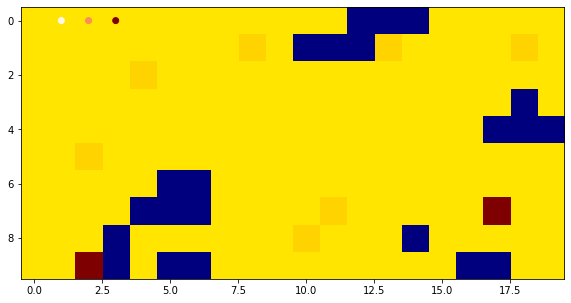

importing Jupyter notebook from h_plotting.ipynb


In [1]:
import import_ipynb
import i_creation_environnement
import matplotlib.pyplot as plt

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
import h_plotting

matplotlib.style.use('ggplot')
import time

In [2]:
env = i_creation_environnement.AugmentedGridworldEnv()

# Random Policy

In [3]:
def Random_Policy(env, num_episodes, display_trajectories = False):
    
    # Keeps track of useful statistics
    stats = h_plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    states_trajectories = []
    reward_trajectories = []
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 2 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            #sys.stdout.flush()
        
        if display_trajectories and i_episode%(num_episodes//10)==0:
            states_trajectories.append([])
            reward_trajectories.append([])
        
        # Reset the environment and pick the first action
        env.reset()
        state = 0
        reward = 0
        
        action_probs = np.ones(env.nA, dtype=float) / env.nA       
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count(): #generator of integer, continues until break
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            if display_trajectories and i_episode%(num_episodes//10)==0:
                states_trajectories[-1].append(next_state)
                reward_trajectories[-1].append(reward)

            # Pick the next action
            next_action_probs = np.ones(env.nA, dtype=float) / env.nA 
            
            # We avoid getting through the wall by setting the probability to 0
            for i in range(env.nA):
                if env.P[next_state][i][0][0] == 0.0:
                    next_action_probs[i] = 0
                    norm = np.linalg.norm(next_action_probs,ord=1)
                    next_action_probs = next_action_probs/norm #we reset the sum of p to be equal to 1 
                
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
                
            action = next_action
            state = next_state   
            
        if display_trajectories and i_episode%(num_episodes//10)==0: #to display the trajectory
            print("Episode length :", len(states_trajectories[i_episode//(num_episodes//10)]))
            env.render_trajectory(states_trajectories[-1], reward_trajectories[-1])
        
    return stats

Episode length : 77


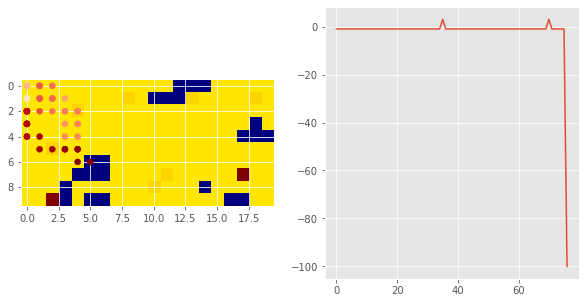

Episode 10/100.Episode length : 85


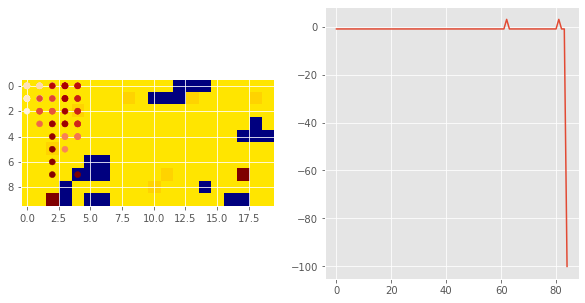

Episode 20/100.Episode length : 34


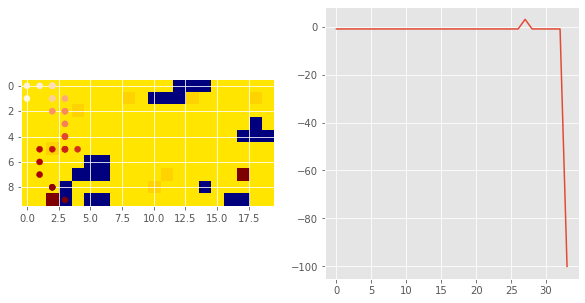

Episode 30/100.Episode length : 118


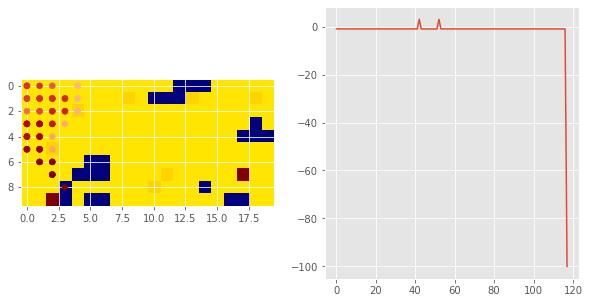

Episode 40/100.Episode length : 34


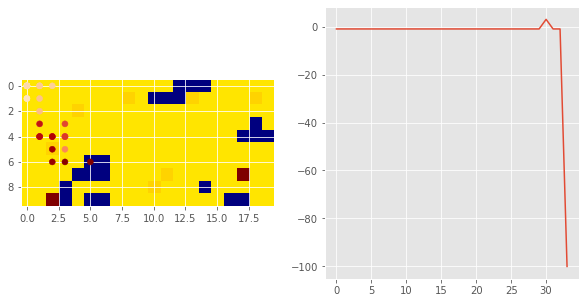

Episode 50/100.Episode length : 48


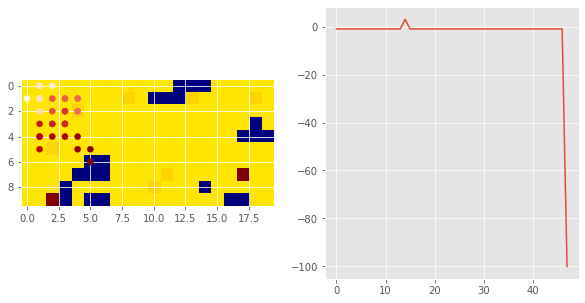

Episode 60/100.Episode length : 66


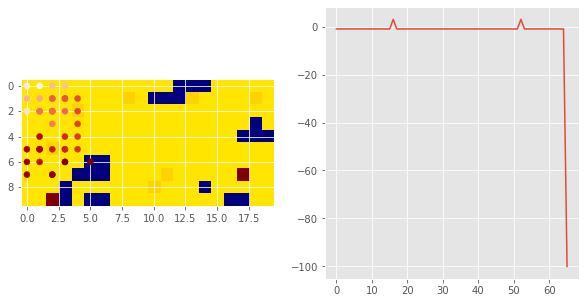

Episode 70/100.Episode length : 43


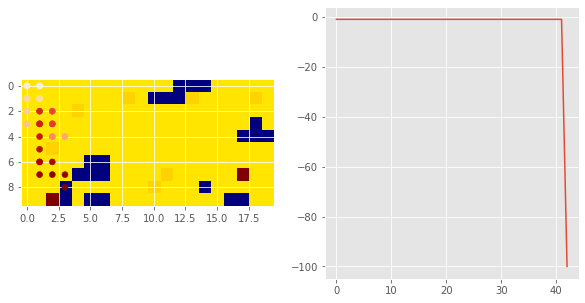

Episode 80/100.Episode length : 128


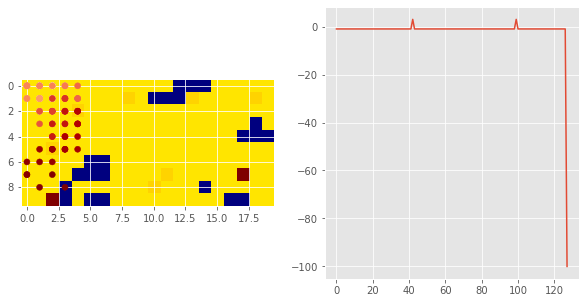

Episode 90/100.Episode length : 82


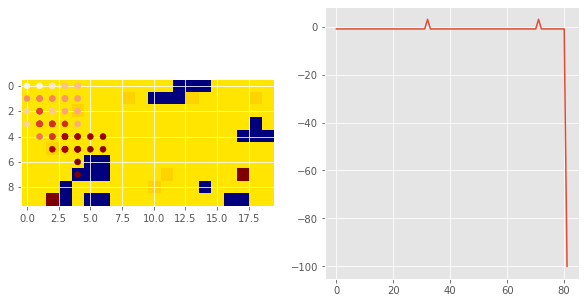

Episode 100/100.

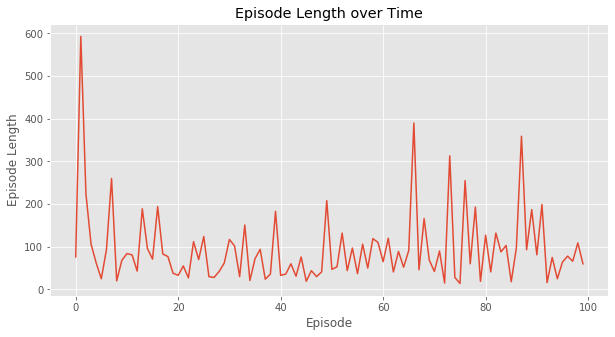

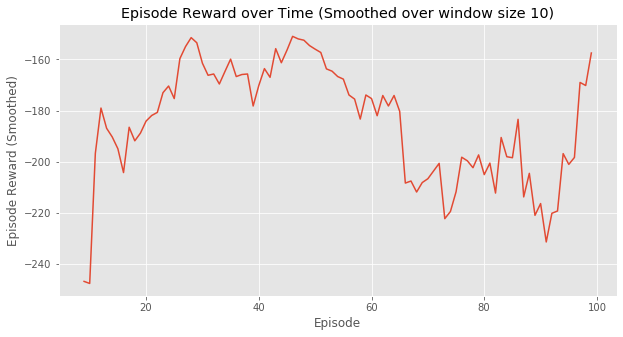

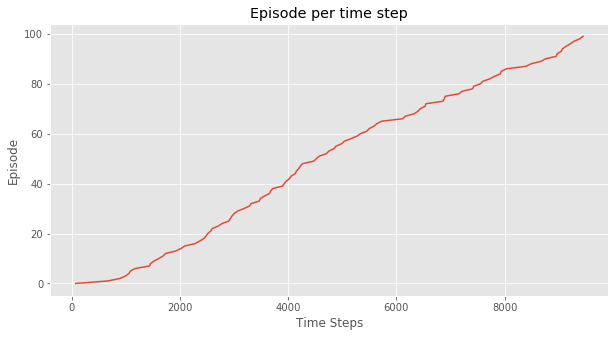


Max reward :  25.0 at episode  94 / 100


In [4]:
if __name__ == '__main__':
    num_epi = 100
    stats_0 = Random_Policy(env, num_episodes = num_epi, display_trajectories=True)
    
    h_plotting.plot_episode_stats(stats_0)
    
    print("")
    i_max = np.argmax(stats_0.episode_rewards)
    print("Max reward : ", stats_0.episode_rewards[i_max], "at episode ", i_max,'/', num_epi)

# SARSA

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def SARSA(env, num_episodes, discount_factor=0.99, alpha=0.5, epsilon=0.1, display_trajectories = False):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = h_plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    states_trajectories = []
    reward_trajectories = []
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 2 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            #sys.stdout.flush()
        
        if display_trajectories and i_episode%(num_episodes//10)==0:
            states_trajectories.append([])
            reward_trajectories.append([])
        
        # Reset the environment and pick the first action
        env.reset()
        state = 0
        reward = 0
        
        action_probs = policy(state)         
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # One step in the environment
        for t in itertools.count(): #generator of integer, continues until break
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            if display_trajectories and i_episode%(num_episodes//10)==0:
                states_trajectories[-1].append(next_state)
                reward_trajectories[-1].append(reward)

            # Pick the next action
            next_action_probs = policy(next_state)
            
            # We avoid getting through the wall by setting the probability to 0
            for i in range(env.nA):
                if env.P[next_state][i][0][0] == 0.0:
                    next_action_probs[i] = 0
                    norm = np.linalg.norm(next_action_probs,ord=1)
                    next_action_probs = next_action_probs/norm
                
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state   
            
        if display_trajectories and i_episode%(num_episodes//10)==0: #to display the trajectory
            print("Episode length :", len(states_trajectories[i_episode//(num_episodes//10)]))
            env.render_trajectory(states_trajectories[-1], reward_trajectories[-1])
        
    return Q, stats

Episode length : 246


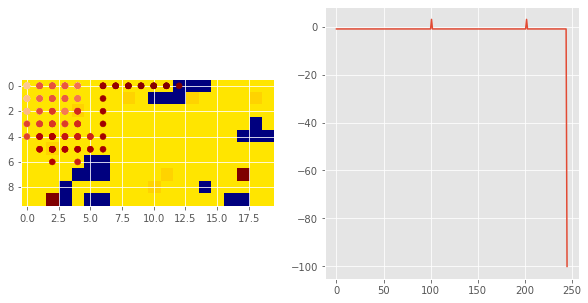

Episode 150/1500.Episode length : 22


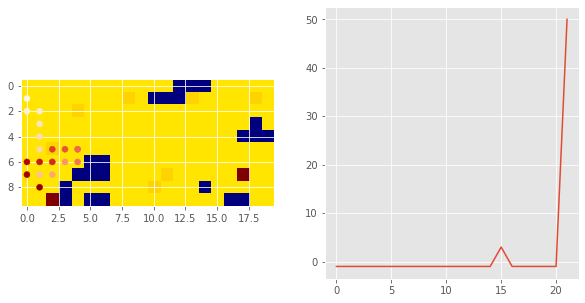

Episode 300/1500.Episode length : 16


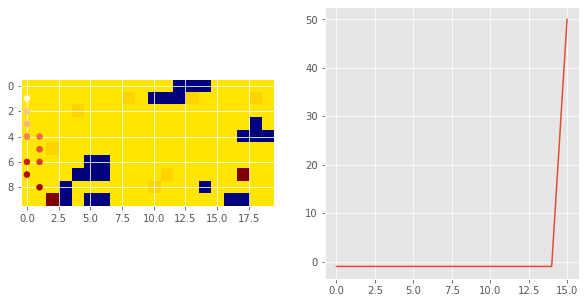

Episode 450/1500.Episode length : 14


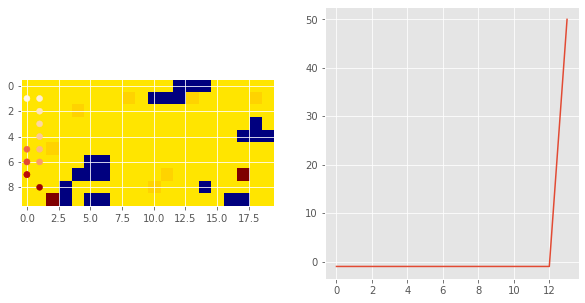

Episode 600/1500.Episode length : 29


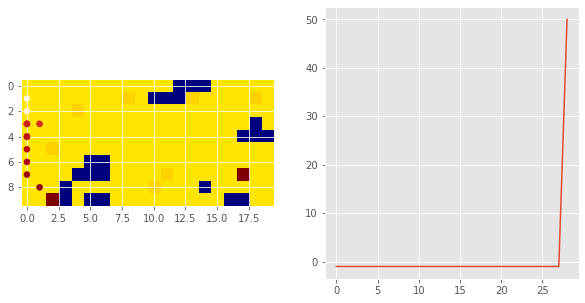

Episode 750/1500.Episode length : 9


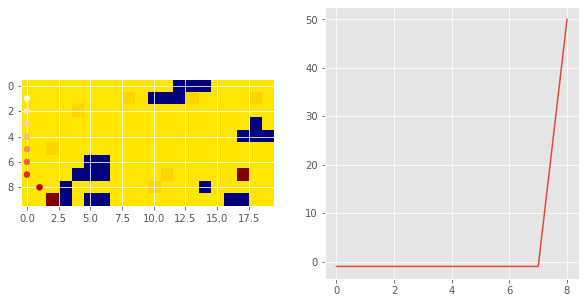

Episode 900/1500.Episode length : 11


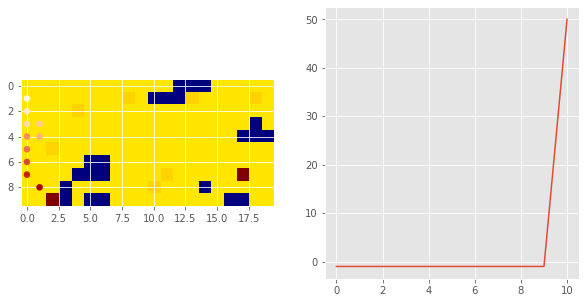

Episode 1050/1500.Episode length : 19


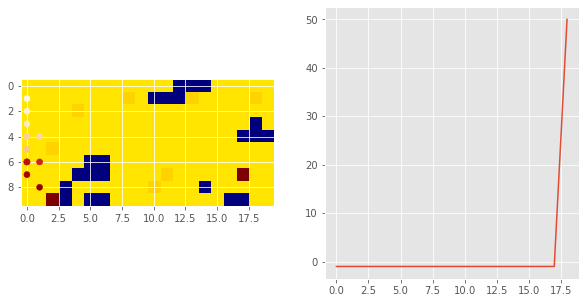

Episode 1200/1500.Episode length : 17


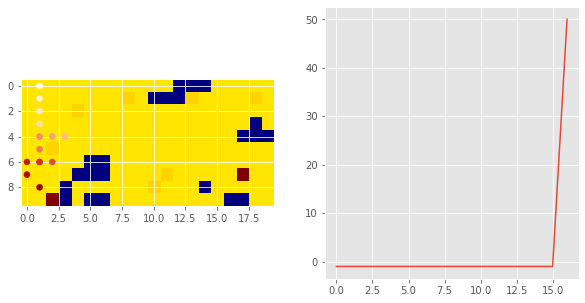

Episode 1350/1500.Episode length : 13


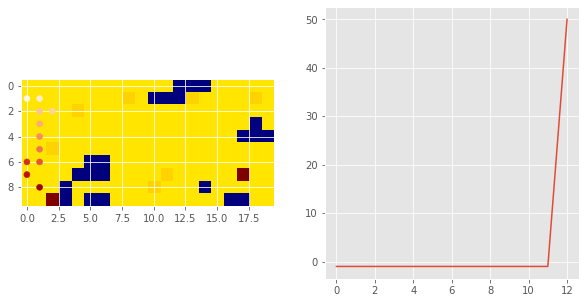

Episode 1500/1500.Running time :  1.5293740550676982 minutes


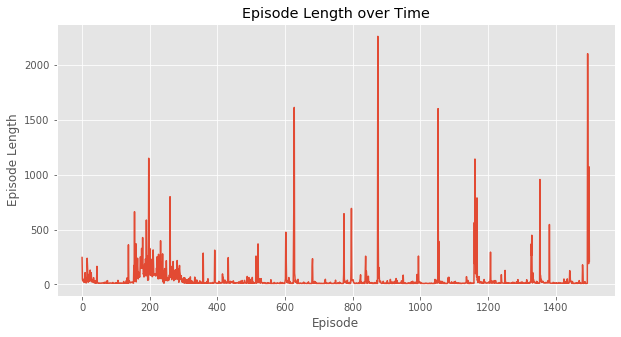

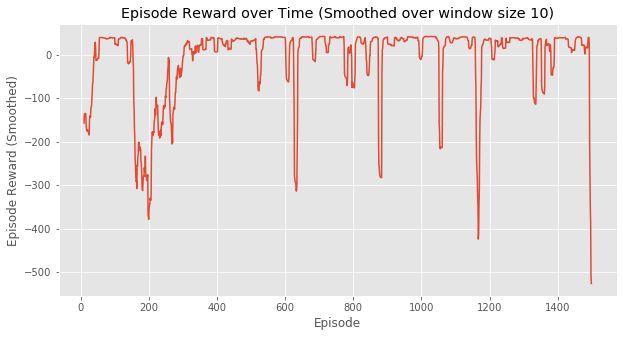

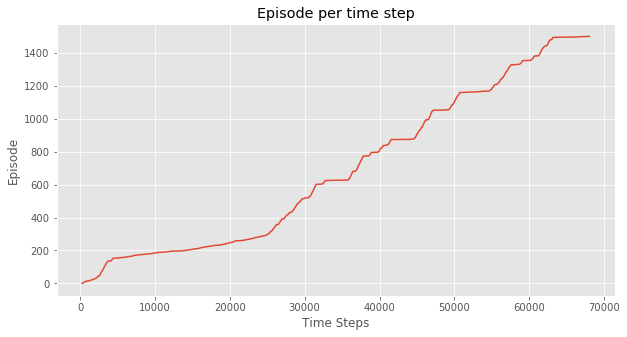

Max reward :  42.0 at episode  349 / 1500


In [7]:
if __name__ == '__main__':
    t0 = time.time()
    num_epi = 1500
    Q_1, stats_1 = SARSA(env, num_episodes = num_epi, epsilon = 0.1, display_trajectories=True)
    t1 = time.time()
    
    print("Running time : ", (t1-t0)/60, "minutes")
    
    h_plotting.plot_episode_stats(stats_1)
    
    i_max = np.argmax(stats_1.episode_rewards)
    print("Max reward : ", stats_1.episode_rewards[i_max], "at episode ", i_max,'/', num_epi)

# Q LEARNING

In [8]:
def Q_learning(env, num_episodes, discount_factor=0.99, alpha=0.5, epsilon=0.1, display_trajectories = False):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = h_plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #Some exemples of trajectories
    states_trajectories = []
    reward_trajectories = []
    
    for i_episode in range(num_episodes):
        
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 2 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            #sys.stdout.flush()
        
        if display_trajectories and i_episode%(num_episodes//10)==0:
            states_trajectories.append([])
            reward_trajectories.append([])
        
        # Reset the environment and pick the first action
        env.reset()
        state = 0
        
        # One step in the environment
        for t in itertools.count():
        
            # Take a step
            action_probs = policy(state)
            
            # We avoid getting through the wall by setting the probability to 0
            for i in range(env.nA):
                if env.P[state][i][0][0] == 0.0:
                    action_probs[i] = 0
                    norm = np.linalg.norm(action_probs,ord=1)
                    action_probs = action_probs/norm
                    
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            
            if display_trajectories and i_episode%(num_episodes//10)==0:
                states_trajectories[i_episode//(num_episodes//10)].append(next_state)
                reward_trajectories[i_episode//(num_episodes//10)].append(reward)
                
            if done:
                break
                
            state = next_state
        
        if display_trajectories and i_episode%(num_episodes//10)==0: #to display the trajectory
            #print(reward_trajectories[-1])
            print("Episode length :", len(states_trajectories[i_episode//(num_episodes//10)]))
            env.render_trajectory(states_trajectories[-1],reward_trajectories[-1])
    
    return Q, stats

Episode length : 161


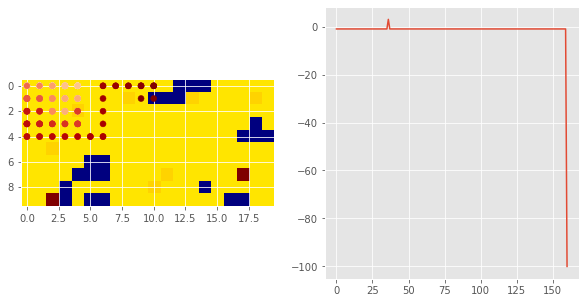

Episode 150/1500.Episode length : 31


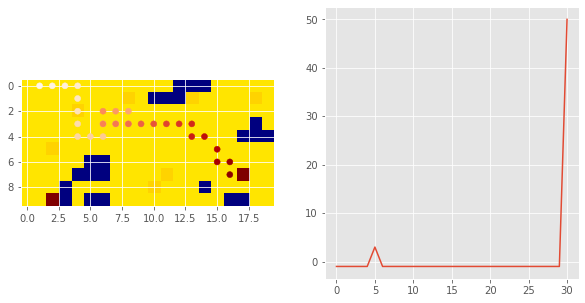

Episode 300/1500.Episode length : 34


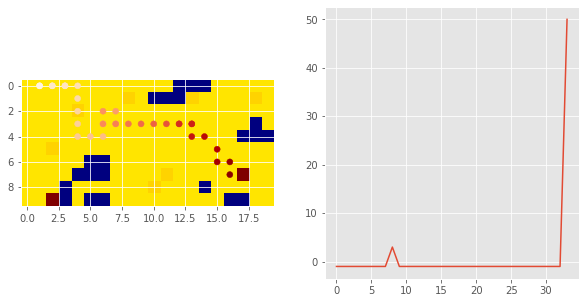

Episode 450/1500.Episode length : 33


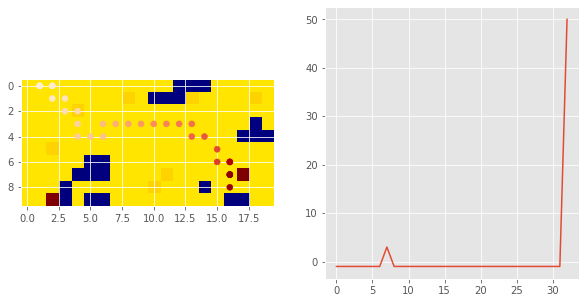

Episode 600/1500.Episode length : 27


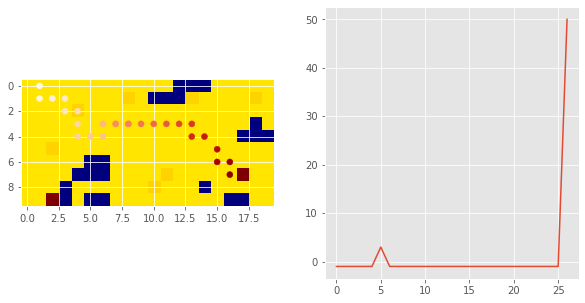

Episode 750/1500.Episode length : 37


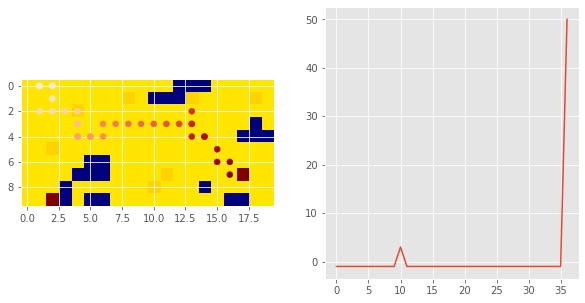

Episode 900/1500.Episode length : 29


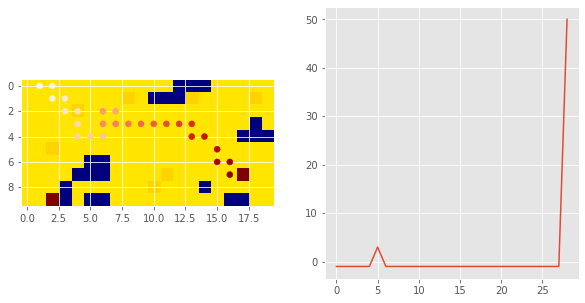

Episode 1050/1500.Episode length : 33


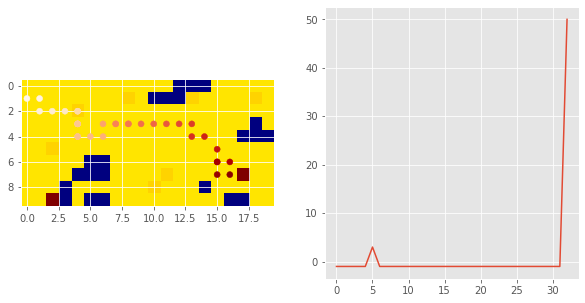

Episode 1200/1500.Episode length : 29


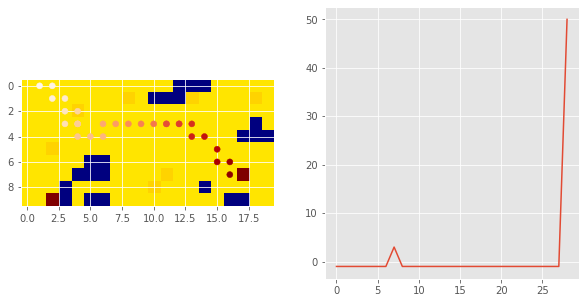

Episode 1350/1500.Episode length : 27


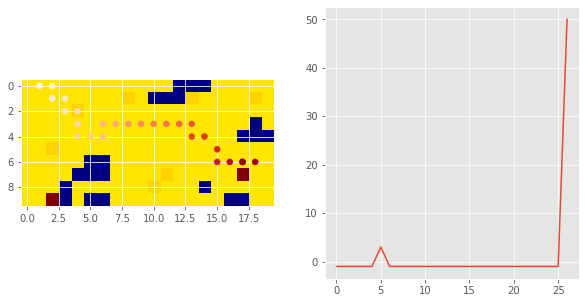

Episode 1500/1500.Running time :  2.3910847465197245 minutes


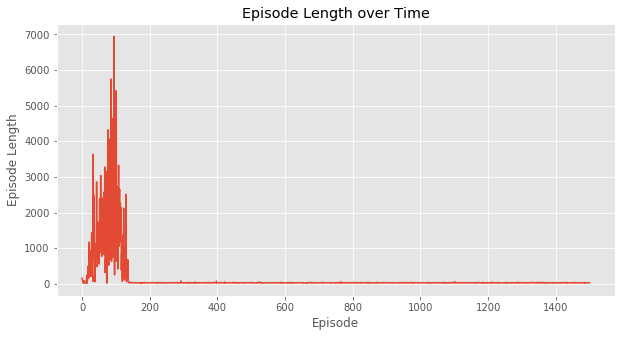

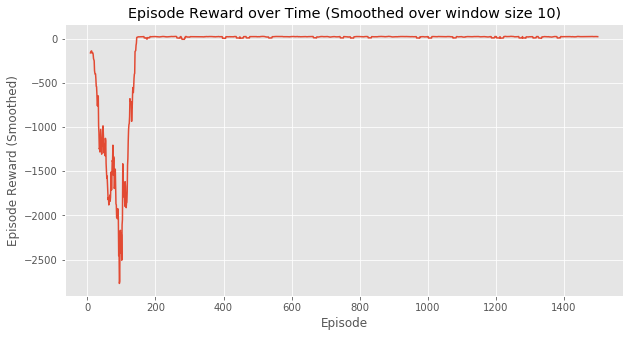

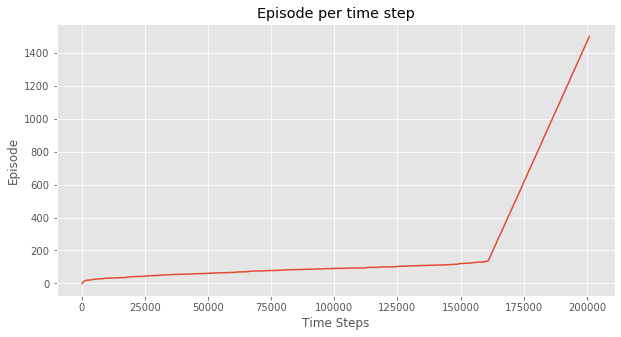

Max reward :  32.0 at episode  73 / 1500


In [9]:
if __name__ == '__main__':
    t0 = time.time()
    num_epi = 1500
    Q_2, stats_2 = Q_learning(env, num_epi, epsilon = 0.15, display_trajectories=True)
    t1 = time.time()
    
    print("Running time : ", (t1-t0)/60, "minutes")
    
    h_plotting.plot_episode_stats(stats_2)
    
    i_max = np.argmax(stats_2.episode_rewards)
    print("Max reward : ", stats_2.episode_rewards[i_max], "at episode ", i_max,'/', num_epi)

In [10]:
def cummax(L):
    return [L[0]] + [np.max(L[:i]) for i in range(1,len(L))]

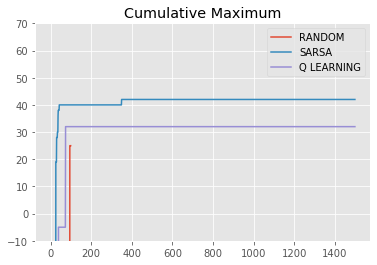

In [11]:
if __name__ == '__main__':
    plt.plot(cummax(stats_0.episode_rewards), label='RANDOM')
    plt.plot(cummax(stats_1.episode_rewards), label = 'SARSA')
    plt.plot(cummax(stats_2.episode_rewards), label= 'Q LEARNING')
    plt.legend()
    plt.ylim((-10,70))
    plt.title('Cumulative Maximum')
    plt.show()